In [2]:
import os
import datetime

OBSV_DATES_APERS = {
    datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d"): 11,
    datetime.date(year=2022, month=12, day=7).strftime("%Y-%m-%d"): 16,
    datetime.date(year=2022, month=12, day=9).strftime("%Y-%m-%d"): 18,
    datetime.date(year=2022, month=12, day=10).strftime("%Y-%m-%d"): 10,
}

# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

QPHOT_DATA_DIRS = [os.path.join(OBJ_DATA_DIR, d, "qphot-results") for d in OBSV_DATES_APERS.keys()]
for qphotDir in QPHOT_DATA_DIRS:
    assert os.path.exists(qphotDir), f"{qphotDir} not found"

QPHOT_DATA_DIRS

['/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-10/qphot-results']

In [125]:
import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
import astropy.units as u
from scipy import stats
from astropy.io import ascii
from astropy.timeseries import TimeSeries

allObjDf = pd.DataFrame()
for (obsvDate, rapert), qphotDir in zip(OBSV_DATES_APERS.items(), QPHOT_DATA_DIRS):
    print(obsvDate, qphotDir, rapert)
    qphotResults = ascii.read(os.path.join(qphotDir, "phot")).to_pandas()
    qphotResults = qphotResults[qphotResults['LID'] == 1]
    qphotResults['OTIME'] = pd.to_datetime(qphotResults['OTIME'])

    apertureCols = [c for c in qphotResults.columns if c.startswith('RAPERT')]
    apertureIds = [c[-1] for c in apertureCols]
    for apCol in apertureCols:
        colRadius = qphotResults.loc[qphotResults.index[0], apCol]
        if colRadius == rapert:
            apertureCols.remove(apCol)
            apId = apCol.replace("RAPERT", "")
            apertureIds.remove(apId)
            qphotResults.drop(columns=[c for c in qphotResults.columns if c[-1] in apertureIds], inplace=True)
            renamedCols = {colName:colName[:-1] for colName in qphotResults.columns if colName.endswith(apId) }
            qphotResults.rename(columns=renamedCols, inplace=True)
            break
    qphotResults = qphotResults[(np.abs(stats.zscore(qphotResults['MAG'], nan_policy='omit')) < 2)]
    qphotResults['obsv_date'] = obsvDate
    allObjDf = pd.concat([allObjDf, qphotResults], ignore_index=True)

objTimeSeries = TimeSeries(time=allObjDf['OTIME'], 
                           data={'mag': allObjDf['MAG']*u.mag, 'err': allObjDf['MERR']*u.mag, 'flux': allObjDf['FLUX']*u.ct, 'obsv_date': allObjDf['obsv_date']})
objTimeSeries

2022-12-06 /run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/qphot-results 11
2022-12-07 /run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/qphot-results 16
2022-12-09 /run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/qphot-results 18
2022-12-10 /run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-10/qphot-results 10


time,mag,err,flux,obsv_date
,mag,mag,ct,
Time,float64,float64,float64,object
2022-12-06T19:13:29.890000000,18.039,0.031,36513.59,2022-12-06
2022-12-06T19:14:30.021000000,17.942,0.018,39941.45,2022-12-06
2022-12-06T19:15:30.170000000,18.009,0.02,37529.81,2022-12-06
2022-12-06T19:16:30.296000000,18.039,0.026,36537.79,2022-12-06
2022-12-06T19:17:30.435000000,18.027,0.02,36923.18,2022-12-06
2022-12-06T19:18:30.565000000,17.973,0.02,38796.73,2022-12-06
2022-12-06T19:19:30.706000000,18.056,0.027,35940.02,2022-12-06
2022-12-06T19:20:30.835000000,17.956,0.021,39423.55,2022-12-06


Periodo: 4.0253170634126825 hr
Frecuencia: 5.962263250799103 d^-1
(Max power)^2: 5164.570123270817, 18356218.61945653


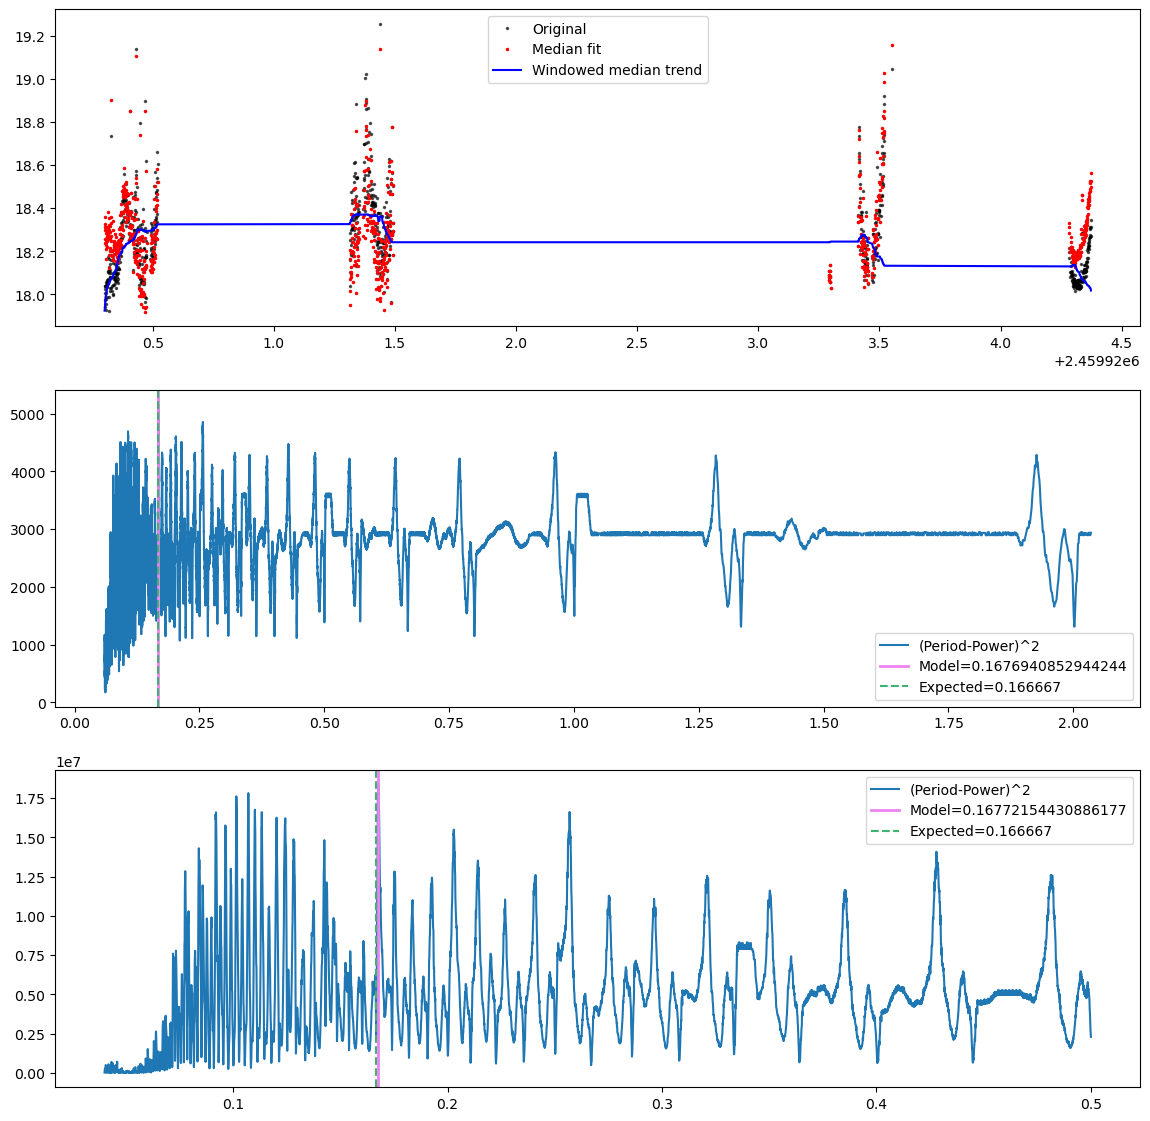

In [163]:
from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.signal import medfilt

import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use("science")
# plt.rcParams["figure.figsize"] = (15,6)

copyTs = objTimeSeries.copy()
# trend = medfilt(copyTs['flux'], 191)
# copyTs['flux'] = (copyTs['flux'] - (trend*u.ct)) + np.median(objTimeSeries['flux'])
trend = medfilt(copyTs['mag'], 191)
copyTs['mag'] = (copyTs['mag'] - (trend*u.mag)) + np.median(objTimeSeries['mag'])

figure, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

# axs[0].plot(objTimeSeries.time_bin_start.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")
# axs[0].plot(copyTs.time_bin_start.jd, copyTs['flux'], 'r.', markersize=3, label="Median fit")

# axs[0].plot(objTimeSeries.time_bin_center.jd, objTimeSeries['mag'], 'k.', markersize=3, label="Original", alpha=0.6)
# axs[0].plot(copyTs.time_bin_center.jd, copyTs['mag'], 'r.', markersize=3, label="Median fit")
# axs[0].plot(copyTs.time_bin_center.jd, trend, color='blue', label="Windowed median trend")

axs[0].plot(objTimeSeries.time.jd, objTimeSeries['mag'], 'k.', markersize=3, label="Original", alpha=0.6)
axs[0].plot(copyTs.time.jd, copyTs['mag'], 'r.', markersize=3, label="Median fit")
axs[0].plot(copyTs.time.jd, trend, color='blue', label="Windowed median trend")

model = BoxLeastSquares.from_timeseries(copyTs, signal_column_name="mag", uncertainty="err")
# model = BoxLeastSquares.from_timeseries(objTimeSeries, signal_column_name="mag", uncertainty="err")
# model = BoxLeastSquares.from_timeseries(copyTs, signal_column_name="flux")

transitDurationsTest = np.linspace(0.005, 0.03, 50)*u.day

autoPeriodogram = model.autopower(transitDurationsTest, objective='snr')
bestPeriod = autoPeriodogram.period[np.argmax(autoPeriodogram.power)]

axs[1].plot(autoPeriodogram.period, np.power(autoPeriodogram.power, 2), label="(Period-Power)^2")
# axs[1].plot(autoPeriodogram.period, autoPeriodogram.power, color="orange", label="Period-Power")
axs[1].axvline(bestPeriod.value, color='violet', linestyle='-', label=f"Model={bestPeriod.value}", linewidth=2)

periods = np.linspace(0.04, 0.5, 5000)*u.d
explicitPeriodogram = model.power(periods, transitDurationsTest)
bestPeriod = explicitPeriodogram.period[np.argmax(explicitPeriodogram.power)]

axs[2].plot(explicitPeriodogram.period, np.power(explicitPeriodogram.power, 2), label="(Period-Power)^2")
# axs[2].plot(explicitPeriodogram.period, explicitPeriodogram.power, color="orange", label="Period-Power")
axs[2].axvline(bestPeriod.value, color='violet', linestyle='-', label=f"Model={bestPeriod.value}", linewidth=2)

axs[1].axvline(0.166667, color='mediumseagreen', linestyle='--', label="Expected=0.166667")
axs[2].axvline(0.166667, color='mediumseagreen', linestyle='--', label="Expected=0.166667")


[ax.legend() for ax in axs]
print(f"Periodo: {bestPeriod.value * 24} hr")
print(f"Frecuencia: {1.0 / bestPeriod.value} d^-1")
print(f"(Max power)^2: {autoPeriodogram.power[np.argmax(autoPeriodogram.power)]**2}, {explicitPeriodogram.power[np.argmax(explicitPeriodogram.power)]**2}")

In [146]:
index = np.argmax(explicitPeriodogram.power)

period = explicitPeriodogram.period[index]
transitTime = explicitPeriodogram.transit_time[index]
transitDuration = explicitPeriodogram.duration[index]

periodogramStats = model.compute_stats(period, transitDuration, transitTime)
periodogramStats

{'transit_times': <Time object: scale='utc' format='datetime64' value=['2022-12-06T22:52:22.690000000' '2022-12-07T02:53:53.831428286'
  '2022-12-07T06:55:24.972856571' '2022-12-07T10:56:56.114284857'
  '2022-12-07T14:58:27.255713143' '2022-12-07T18:59:58.397141428'
  '2022-12-07T23:01:29.538569714' '2022-12-08T03:03:00.679998000'
  '2022-12-08T07:04:31.821426285' '2022-12-08T11:06:02.962854571'
  '2022-12-08T15:07:34.104282857' '2022-12-08T19:09:05.245711142'
  '2022-12-08T23:10:36.387139428' '2022-12-09T03:12:07.528567714'
  '2022-12-09T07:13:38.669995999' '2022-12-09T11:15:09.811424285'
  '2022-12-09T15:16:40.952852571' '2022-12-09T19:18:12.094280856'
  '2022-12-09T23:19:43.235709142' '2022-12-10T03:21:14.377137427'
  '2022-12-10T07:22:45.518565713' '2022-12-10T11:24:16.659993999'
  '2022-12-10T15:25:47.801422284' '2022-12-10T19:27:18.942850570']>,
 'per_transit_count': array([43,  0,  0,  0,  0,  0, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        11, 24,  0,  0,  0,  0, 43]),
 

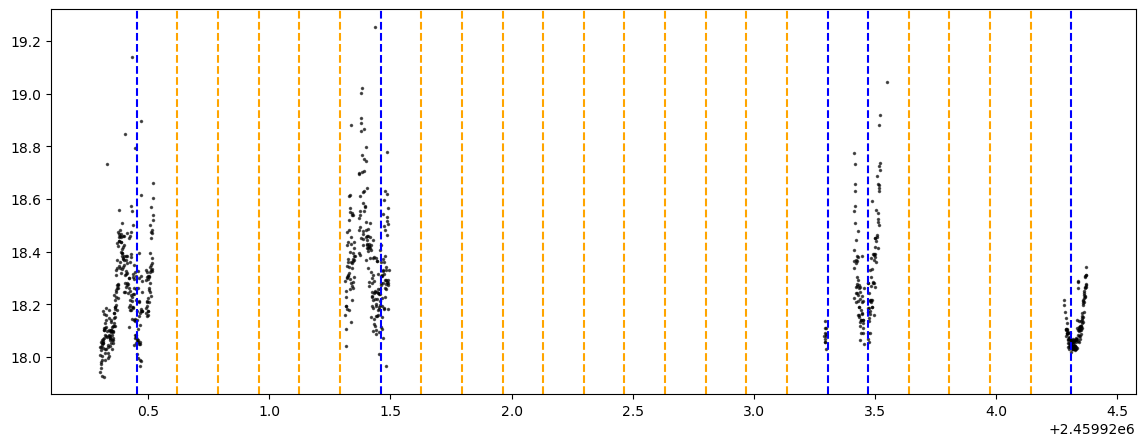

In [147]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))

ax.plot(objTimeSeries.time.jd, objTimeSeries['mag'], 'k.', markersize=3, label="Original", alpha=0.6)

i = 0
for tt in periodogramStats['transit_times']:
    lineColor = "blue" if periodogramStats['per_transit_count'][i] != 0 else "orange"
    ax.axvline(tt.jd, linestyle='--', color=lineColor)
    i = i + 1

time,mag,err,flux,obsv_date
,mag,mag,ct,
float64,float64,float64,float64,object
0.09373598587853611,18.039,0.031,36513.59,2022-12-06
0.09788548647499146,17.942,0.018,39941.45,2022-12-06
0.10203622920962557,18.009,0.02,37529.81,2022-12-06
0.10618538476769893,18.039,0.026,36537.79,2022-12-06
0.11033543742556702,18.027,0.02,36923.18,2022-12-06
0.11448486901434672,17.973,0.02,38796.73,2022-12-06
0.118635059687568,18.056,0.027,35940.02,2022-12-06
0.12278442226867142,17.956,0.021,39423.55,2022-12-06


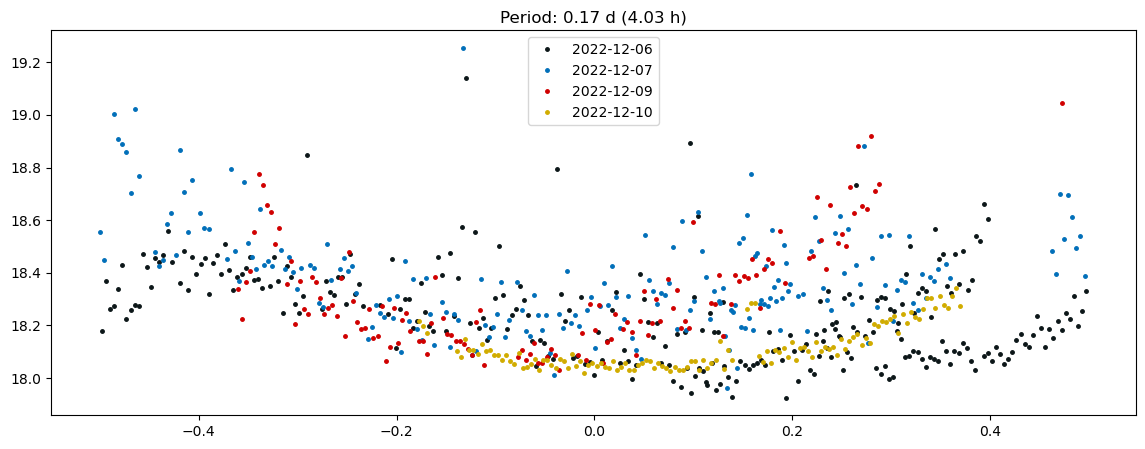

In [162]:
tsObsvDates = allObjDf['obsv_date'].unique()
dateColors = ['#0c1618', '#016fb9', '#d00000', '#d1ac00']

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
foldedTs = objTimeSeries.fold(period=period, epoch_time=transitTime, normalize_phase=True)

for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[objTimeSeries['obsv_date'] == obsvDate]
    ax.plot(obsvPoints.time.value, obsvPoints['mag'], '.', color=color, markersize=5, label=obsvDate)
ax.legend()
ax.set_title(f"Period: {period:.2f} ({period.value * 24:.2f} h)")
foldedTs